In [1]:
import cv2

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import scipy
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

from Analyzer import *

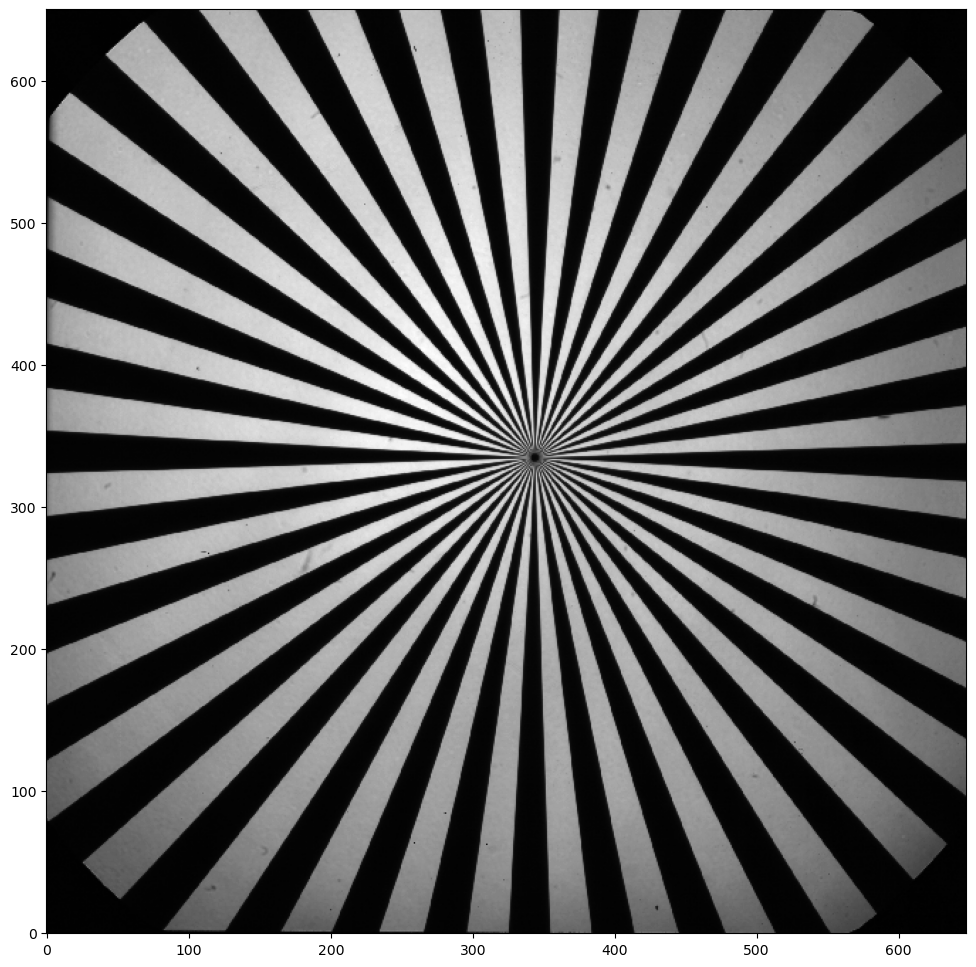

In [3]:
data = cv2.imread("ss.png",cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(18,12))

plt.imshow(data,origin='lower',cmap='gray')

plt.show()

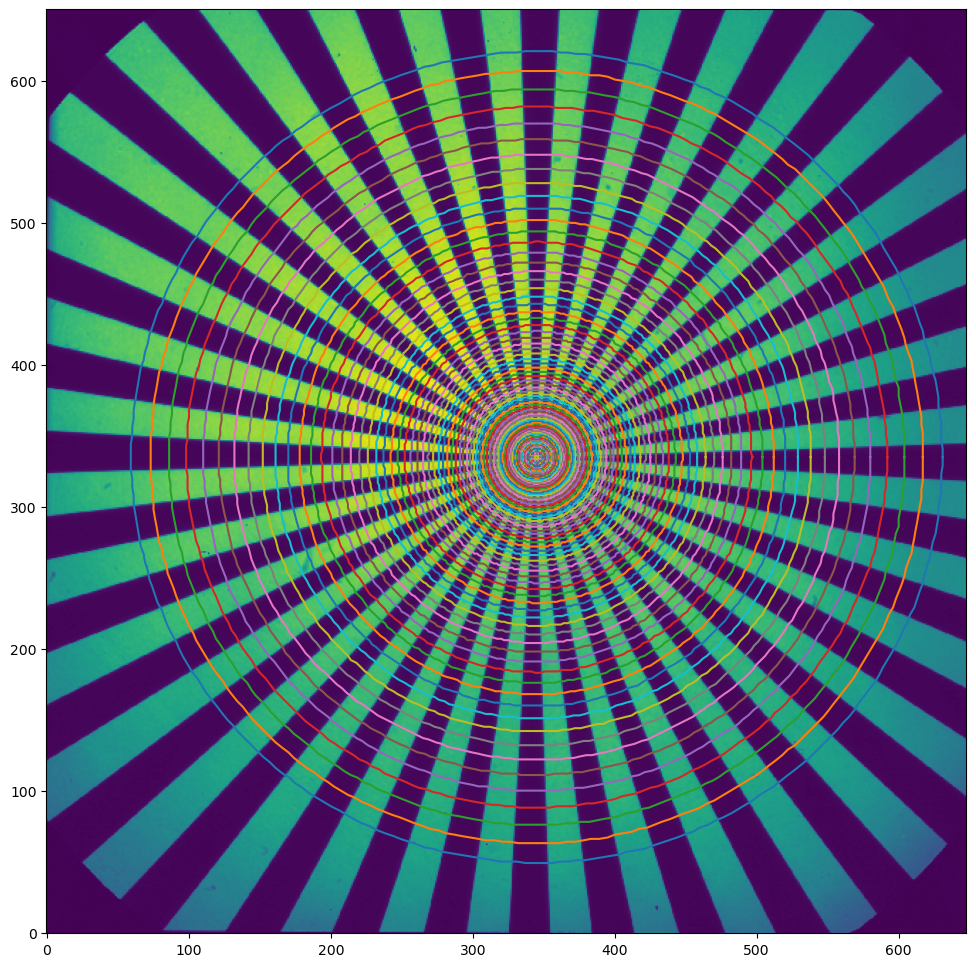

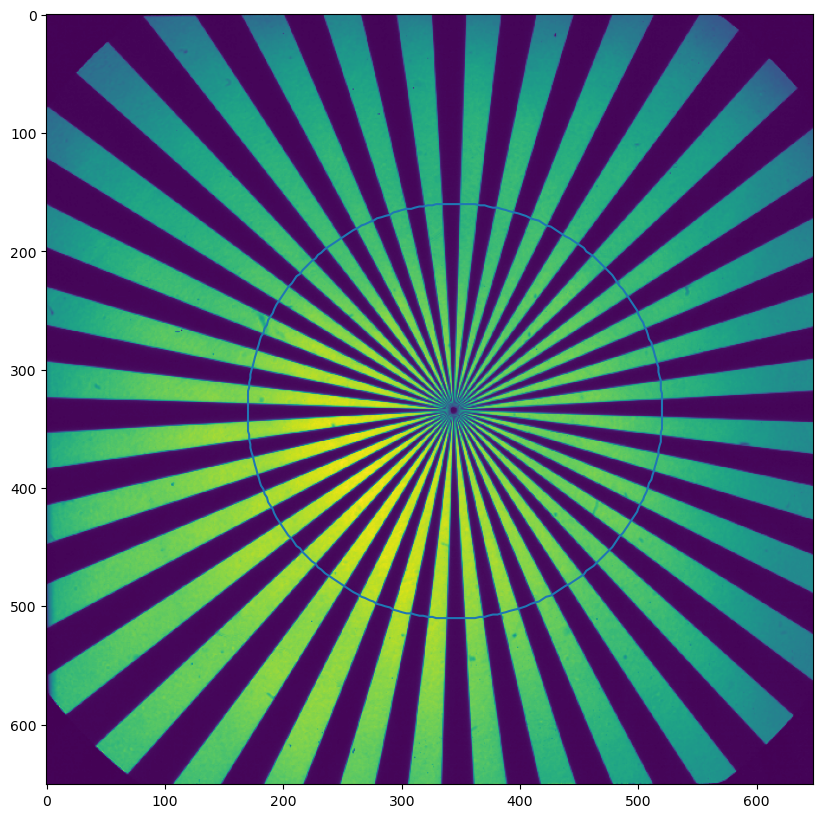

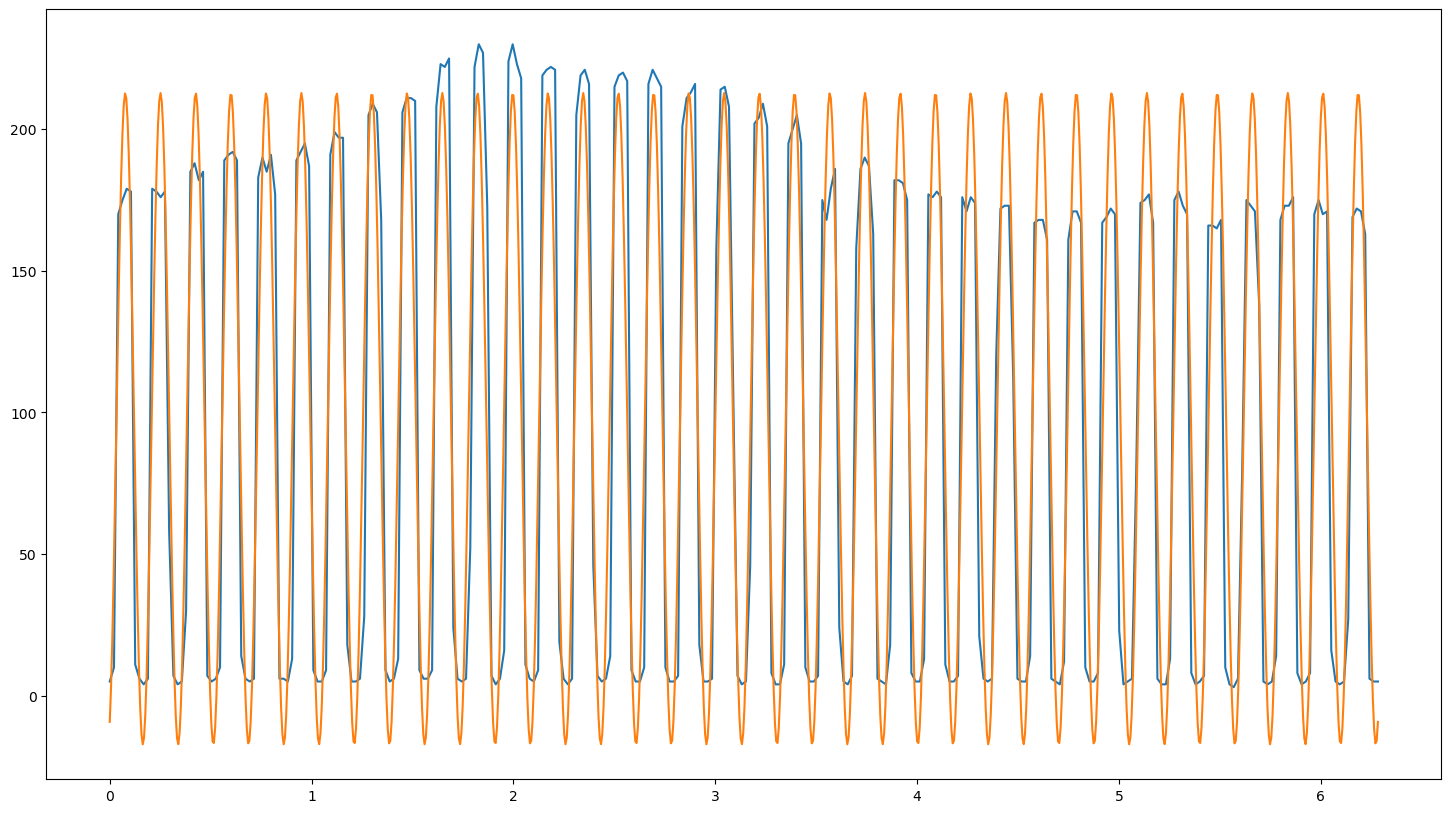

In [4]:
shape   = data.shape[0]
R_max   = 300
N_theta = 300
theta   = np.linspace(0, 2*np.pi, N_theta) 
N_radii = 120
radii   = R_max*1/1.05**np.arange(1, N_radii) ## we take a logarithmic range of radii

N_p     = 36      # angular frequency (number of dark (bright) lines)

# center of the target (determined manually)
x_c     = 345
y_c     = 335

plt.figure(figsize=(18,12))
plt.imshow(data, origin='lower')
for r in radii:

    freq = get_freq(r, N_p)
    I,x,y = get_line(data,theta,r,x_c,y_c)
    plt.plot(x,y)

r      = radii[10]
I,x,y  = get_line(data,theta,r,x_c,y_c)

p0     = [(I.max()-I.min())/2, (I.max() -(I.max()-I.min())/2)/5, -(I.max()-I.min())/2 ]
m,popt = fit_sinusoid(I,theta,p0)

plt.figure(figsize=(18,10)) 
plt.imshow(data)
ax = plt.gca() 
ax.set_aspect(1) 
plt.plot(x,y)


plt.figure(figsize=(18,10))
plt.plot(theta,I)
xnew = np.linspace(0,theta.max(),1000)
ynew = sinusoidal(xnew,*popt)
plt.plot(xnew,ynew)

C:\Users\Karthik\AppData\Local\Temp\ipykernel_13568\853626961.py:77: RuntimeWarning: invalid value encountered in arccos
  phi = np.arccos(freq_all/freq_c)


<Figure size 640x480 with 0 Axes>

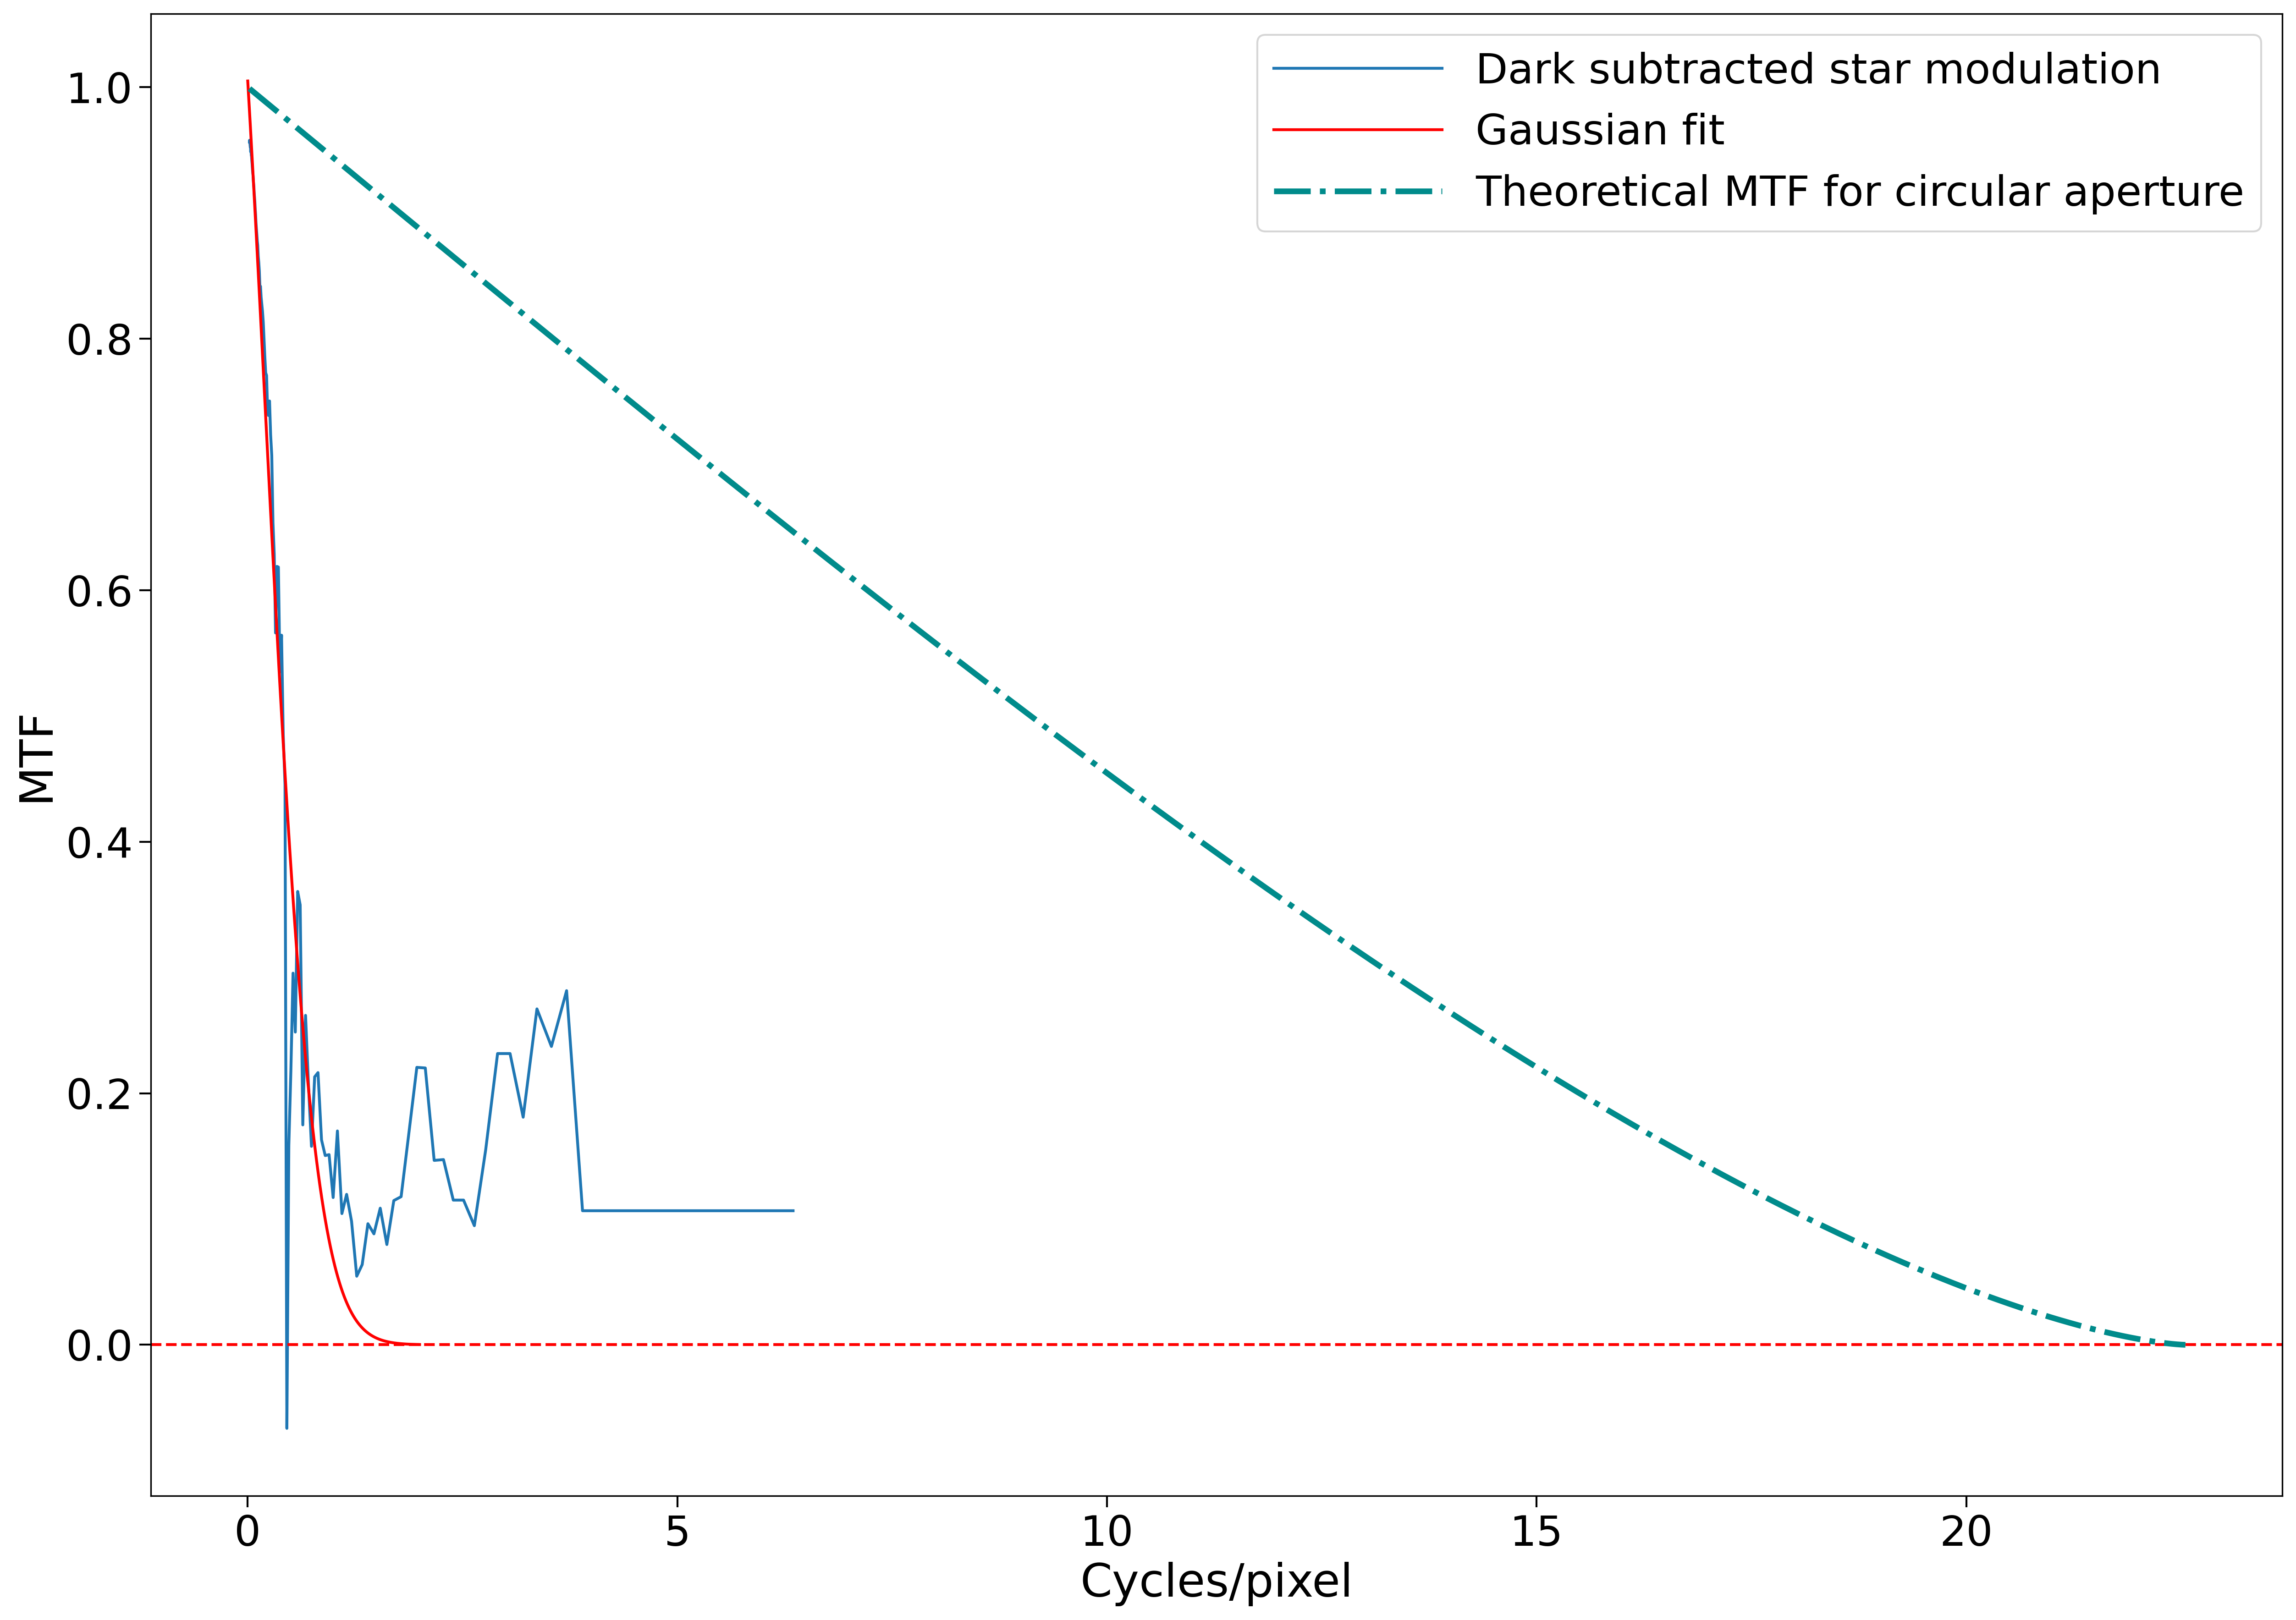

In [24]:
lines = np.zeros((N_radii,2))
n=0
for r in radii:

    freq = N_p/(2*np.pi*r)
    I,x,y = get_line(data,theta,r,x_c,y_c)

    if freq<0.45:
        yhat = savgol_filter(I, 11, 2)
    elif freq>=0.45:
        yhat = savgol_filter(I, 15, 2) 

    maximums = scipy.signal.argrelextrema(yhat, np.greater,order=2)
    minimums = scipy.signal.argrelextrema(yhat, np.less,order=2)


    m = (I[maximums].mean() - I[minimums].mean())/(I[maximums].mean() + I[minimums].mean())

    lines[n][0] = freq; lines[n][1] = m

    n=n+1

plt.clf()
figure=plt.figure(figsize=(20,14),dpi=300)
ax = figure.add_subplot(111)
ax.set_xlabel('Cycles/pixel',fontsize=24)
ax.set_ylabel('MTF',fontsize=24)
# major_ticks = np.arange(0, 2,0.5)
# minor_ticks = np.arange(0, 2, 0.1)
# major_ticks_y = np.arange(0, 1.8,0.2)
# minor_ticks_y = np.arange(0, 1.8, 0.05)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor = True)
# ax.set_yticks(major_ticks_y)
# ax.set_yticks(minor_ticks_y, minor = True)
ax.tick_params(axis = 'both', which = 'major', length=6, width=1,labelsize = 22)
ax.tick_params(axis = 'both', which = 'minor', length=3, width=1,labelsize=22)


freq_all = lines[:,0]
M_all = lines[:,1]

# remove last outlier point
freq_all =freq_all[:-1]#/ 0.5
M_all = M_all[:-1]
#M_all =M_all/M_all.max()

## fit MTF with a gaussian
p0_g = [1,0,0.5]
popt, pcov = curve_fit(Gaussian,freq_all[:100],M_all[:100],p0_g,maxfev=8000)
xnew = np.linspace(0,2,1000)
ynew = Gaussian(xnew,*popt)

## perfect MTF (circular aperture, no aberrations):

# D = 
# f = 
# f_stop = f/D

NA = 0.6
lam = 532*10**(-6)

#in pixels
# freq_c = 1/(lam * f_stop * 100)

freq_c = (2*NA)/(lam * 100)

#in arcsec
#freq_c = D/(1.22*lam*206265)

## plot results
plt.plot(freq_all,M_all,label='Dark subtracted star modulation')
plt.plot(xnew,ynew,'r',label='Gaussian fit')
plt.axhline(y=0,linestyle='dashed',color='red')

freq_all = np.arange(0.02, 2*freq_c, 0.01)
phi = np.arccos(freq_all/freq_c)
MTF_p = (2/np.pi)*(phi - (np.cos(phi))*np.sin(phi))
plt.plot(freq_all,MTF_p,label='Theoretical MTF for circular aperture',color='darkcyan',linestyle='-.',linewidth=3)

ax.legend(loc='best',fancybox=True, handlelength=4,fontsize=22)
# ax.set_xlim(0,0.7)